# Image Directory
We've provided a few images from ImageNet. If working locally, update ```DATA_FOLDER``` based on your local directory. Based on the documentation for [ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html), within ```DATA_FOLDER``` you should have one folder for each class, respectively ```'bagel', 'barn', 'goldfish', 'mud_turtle'```. Put each provided image into the respective folder.

We've also provided a file that lists the class names of ImageNet, in order. Update ```CLASSNAMES_FILE``` based on your local directory.

In [1]:
DATA_FOLDER = '/Users/alexwa/Documents/GitHub/TrustworthyDL-1/pset_1/imagenet-images'
CLASSNAMES_FILE = '/Users/alexwa/Documents/GitHub/TrustworthyDL-1/pset_1/imagenet_classnames.txt'

If you're using Colab, we've noticed an issue with hidden files, so uncomment and run the following line:

In [2]:
# rm -rf /content/imagenet-images/.ipynb_checkpoints

# Imports

If you're running this notebook in Colab, you'll want to uncomment and run the following line.

If you're running this notebook locally or on a Grace cluster, you can separately install any packages you use. Note: if your device is GPU-compatible, you'll likely get a significant speed-up in running code for this assignment and the next, but it shouldn't be *strictly* necessary.

In [3]:
!pip install captum

In [4]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.v2 as transforms
import captum

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

# Useful methods
Just run these cells, they contain functions that may be useful for visualizing output in particular.

```means``` and ```stds``` are defined in a later cell.

Notice that ```visualize_attributions``` accepts a List[] of **numpy arrays**.

In [5]:
def unnormalize(img):
    r"""
    Args:
        img (Tensor): Tensor image of size (C, H, W), normalized according to means, stds.
    Returns:
        numpy.ndarray: Unnormalized image of size (H, W, C) in range [0, 1].
    """
    # Convert the Tensor img to a numpy array that can be visualized
    img = img.cpu().permute(1, 2, 0).numpy()
    img = (img * stds[None,None]) + means[None,None]
    img = np.clip(img, a_min=0.0, a_max=1.0)
    return img

In [6]:
def visualize_attributions(predicted_class, predicted_probability, image, attrs, methods, titles):
    r"""
    Output n results, each for the same input image.
    attrs, methods, titles should be the same length, n.
    Args:
        predicted_class (str): Name of class predicted
        predicted_probability (float): Probability assigned to predicted class by model
        image (Tensor): Original image to unnormalize.
        attrs (List[]), methods(List[]), titles (List[]):
            See https://captum.ai/api/utilities.html for documentation on
            captum.attr.visualization.visualize_image_attr.
            Elements of attrs should be numpy arrays of shape (224, 224, 3)
            Use 'blended_heat_map' or 'original_image' for methods.
    """
    print(f"Predicted: {predicted_class} with probability: {predicted_probability}")

    original_image = unnormalize(image.cpu().detach())

    for attr, method, title in zip(attrs, methods, titles):
        if method == 'original_image':
            ones_attr = np.ones(original_image.shape[:2] + (1,), dtype=np.float32)
            _ = viz.visualize_image_attr(
                ones_attr,
                original_image,
                method=method,
                title=title,
            )
        else:
            _ = viz.visualize_image_attr(
                attr,
                original_image,
                method=method,
                sign="all",
                show_colorbar=True,
                title=title,
            )

# Implementation
Here's where you start coding! You will implement the IntegratedGradients [IG](https://arxiv.org/abs/1703.01365) algorithm in the method ```ig_attribution```. The purpose of this exercise is teach you the IG algorithm, as well as to get you accustomed to accessing gradients in PyTorch, which might be helpful on your projects. Feel free to design any helper functions you might need!

I'll bold arguments to the method in this introduction to help you map the description to what you will implement:

IG explains why a **model** predicts a **target class** for a given **input image**. It defines a path from a **baseline image** (for us, the all-zero image) to the input image, and integrates the gradient of the model's score with respect to the path. We will use two different methods of computing [Riemann sums](https://en.wikipedia.org/wiki/Riemann_sum) to approximate the integral of this gradient along a linear path.

To illustrate the difference between the methods, consider approximating the integral of $f(x)=x^3$ from 0 to 25 with 5 subintervals.\
```method_name='riemann',method_side='left'``` will use "rectangles" of
$$(height,start,end)=(0^3,0,5),(5^3,5,10),(10^3,10,15),\dots,(20^3,20,25).$$
```method_name='riemann', method_side='right'``` will use "rectangles" of
$$(height,start,end=(5^3,0,5),(10^3,5,10),(15^3,10,15),\dots,(25^3,20,25).$$
```method_name='quad_linear',method_side='left'``` will use "rectangles" of
$$(height,start,end)=(0^3,0,1),(1^3,1,4),(4^3,4,9),\dots,(16^3,16,25).$$
```method_name='quad_linear',method_side='right'``` will use "rectangles" of
$$(height,start,end)=(1^3,0,1),(4^3,1,4),(9^3,4,9),\dots,(25^3,16,25).$$
That is, ```method_name='quad_linear'``` will simply change the rate at which we move along the **still-linear** path; equivalently, it will change the widths of the subintervals to be non-constant.

By independence of path, the sum of the values of the integrated gradients $sum(IG)$ should equal $model(input)-model(baseline).$ The output ```delta``` is the difference from approximating, so it should be
$$delta=sum(IG) - (model(input)-model(baseline)).$$


In [7]:
def ig_attribution(model, inp, baseline, target_class, method_name, method_side, n_steps):
    r"""
    Args:
        model (nn.Module): The trained model to be explained.
        inp (Tensor): The input to the model.
        baseline (Tensor): The baseline input to compare with.
        target_class (int): Output index for which gradients are computed.
        method_name (str): Method for approximating the integral, one of `riemann` or `quad_linear`.
        method_side (str): Method for approximating the integral, one of `left` or `right`.
        n_steps (int): The number of steps to use in the Riemann approximation.
    Returns:
        attributions (Tensor): Integrated gradients with respect to each input feature. Same shape as inp.
        delta (float): The difference between the total approximated and true integrated gradients.
    """

    ### YOUR CODE HERE:

    model.eval()
    inp = inp.detach().clone()
    baseline = baseline.detach().clone()
    target_class = int(target_class)

    attributions = torch.zeros_like(inp)
    
    if method_name == 'riemann':
        steps = torch.linspace(0, 1, n_steps + 1)
    elif method_name == 'quad_linear':
        uniform_steps = torch.linspace(0, 1, n_steps + 1)
        steps = uniform_steps ** 2
    
    for i in range(n_steps):
        if method_side == 'left':
            step = steps[i]
        elif method_side == 'right':
            step = steps[i + 1]
        
        # x' + a(x - x')
        interpolated = baseline + step * (inp - baseline)
        interpolated = interpolated.requires_grad_(True)
        
        output = model(interpolated)
        target_score = output[0, target_class]
        
        # Compute gradient using torch.autograd.grad (cleaner approach)
        grad = torch.autograd.grad(outputs=target_score, inputs=interpolated, create_graph=False)[0]
        
        # the Riemann sum approximating the gradient
        step_width = steps[i + 1] - steps[i]
        attributions += grad * step_width
    
    # scale by x - x'
    attributions = attributions * (inp - baseline)
    
    # Compute delta
    with torch.no_grad():
        baseline_score = model(baseline)[0, target_class].item()
        input_score = model(inp)[0, target_class].item()
        true_diff = input_score - baseline_score
        approx_diff = attributions.sum().item()
        delta = approx_diff - true_diff

    return attributions, delta

# Data and Model
## Data Processing
We've included a few images from the ImageNet dataset.


In [8]:
# Transformations applied to images before passing them to the model
# Pretrained normalization based on https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
means, stds = [0.485, 0.456, 0.406], [0.485, 0.456, 0.406]
means, stds = np.array(means), np.array(stds)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToImage(), # Converts to tensor
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=means, std=stds)
    ]
)

In [9]:
# Load the small dataset to interpret
dataset = torchvision.datasets.ImageFolder(DATA_FOLDER, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [10]:
# The class names in the dataset are not quite aligned with the class names in the model
my_classes = ('bagel', 'barn', 'goldfish', 'mud turtle')
classes = []
with open(CLASSNAMES_FILE, 'r') as f:
    for line in f:
        classes.append(line.strip())

## Load model
Import torchvision's ResNet18 model. Be sure to use the pretrained weights!

In [11]:
### YOUR CODE HERE:
### Set the model to eval mode so we can interpret it
net = models.resnet18(pretrained = True)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Quick Check
We'll visualize the images, check their ground truths, and output the pretrained ResNet model's predictions (highest-scoring classes) for them.

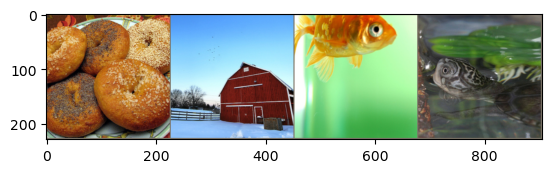

GroundTruth:  bagel  barn goldfish mud turtle
Predicted:  bagel  barn goldfish terrapin


In [12]:
# Load images and labels from the dataset
images_ = torch.stack([dataset[i][0] for i in range(len(my_classes))])
labels_ = [classes.index(my_classes[dataset[i][1]]) for i in range(len(my_classes))]

# Show images
plt.imshow(unnormalize(torchvision.utils.make_grid(images_)))
plt.show()
print("GroundTruth: ", " ".join("%5s" % classes[labels_[j]] for j in range(len(my_classes))))

# Predictions

outputs_ = net(images_)
_, predicted_ = torch.max(outputs_, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted_[j]] for j in range(len(my_classes))))

# Testing

## Config


In [13]:
# Current method to be used for captum visualization
# See https://captum.ai/api/integrated_gradients.html for documentation,
# especially the attribute method.
cur_method_captum = 'riemann_left'
# Current method to be used for self-implemented visualization
cur_method_name, cur_method_side = 'riemann', 'left'

# Choose an image to test on
ind_ = 3
input_tns_ = images_[ind_].unsqueeze(0).requires_grad_()

## Using the Captum library's IG implementation
Use the [documentation](https://captum.ai/api/integrated_gradients.html) for Captum's IG implementation and complete the following function.

In [14]:
def captum_ig(model, inp, baseline, target_class, method, n_steps=50):
    r"""
    Args:
        model (nn.Module): The trained model to be explained.
        inp (Tensor): The input to be explained
        baseline (Tensor): The baseline input to compare with.
        target_class (int): Output index for which gradients are computed.
        method (str): Method for approximating the integral, see Captum documentation for details.
        n_steps (int): The number of steps to use in the integral approximation.
    Returns:
        attributions (Tensor): Integrated gradients with respect to each input feature. Same shape as inp.
        delta (float): The difference between the total approximated and true integrated gradients.
    """

    ### YOUR CODE HERE:
    model.eval()

    inp = inp.detach().clone().requires_grad_(True)
    baseline = baseline.detach().clone()

    model.zero_grad(set_to_none=True)
    
    ig = captum.attr.IntegratedGradients(model)
    attr_ig, delta = ig.attribute(
        inp, 
        baselines = baseline, 
        target = target_class, 
        n_steps = n_steps,
        method = method,
        return_convergence_delta = True)
        
    return attr_ig, delta

Once you've done this, the following code block should run:

In [15]:
attr_ig_captum_, delta_captum_ = captum_ig(net, input_tns_, input_tns_ * 0, labels_[ind_], cur_method_captum, 5)
# what's the lower bound on error of the approximated integral
print("Approximation delta: ", abs(delta_captum_))

Approximation delta:  tensor([7.0258])


In [22]:
input_tns_.shape

torch.Size([1, 3, 224, 224])

## Using your implementation of IG
If you've done ```ig_attribution``` right, ```self_ig``` should essentially look like the ```captum_ig```.

In [16]:
def self_ig(model, inp, baseline, target_class, method_name, method_side, n_steps=50):
    r"""
    Args:
        model (nn.Module): The trained model to be explained.
        inp (Tensor): The input to the model.
        baseline (Tensor): The baseline input to compare with.
        target_class (int): Output index for which gradients are computed.
        method_name (str): Method for approximating the integral, one of `riemann` or `quad_linear`.
        method_side (str): Method for approximating the integral, one of `left` or `right`.
        n_steps (int): The number of steps to use in the Riemann approximation.
    Returns:
        attributions (Tensor): Integrated gradients with respect to each input feature. Same shape as inp.
        delta (float): The difference between the total approximated and true integrated gradients.
    """

    ### YOUR CODE HERE:
    attr_ig, delta = ig_attribution(model, inp, baseline, target_class, method_name, method_side, n_steps)

    return attr_ig, delta

Once you've done this, the following code block should run, and the output should be the same as the approximation delta from ```captum_ig```.

In [17]:
attr_ig_, delta_ = self_ig(net, input_tns_, input_tns_ * 0, labels_[ind_], cur_method_name, cur_method_side, 5)
print("Approximation delta: ", abs(delta_))

Approximation delta:  7.025798559188843


# Comparison
Choose one of the given 4 images and choose an image of your own.

Use Captum (a ```riemann``` method), your implementation of ```riemann```, and your implementation of ```quad_linear``` to explain each image. Be sure to visualize the image and each explanation (```visualize_attributions``` should help) and check the approximation deltas. Comment on the results. It may be interesting to try with the ground truth, the predicted class, or a random class as the target.

(You can choose whether to use right or left -- use the same side for a given image, though.)

(We used 50 steps. You may use however many steps you'd like -- be consistent.)

Deltas: captum=0.0533, self_riemann=0.0512, self_quad=0.1672
Predicted: goldfish with probability: 0.9823741912841797


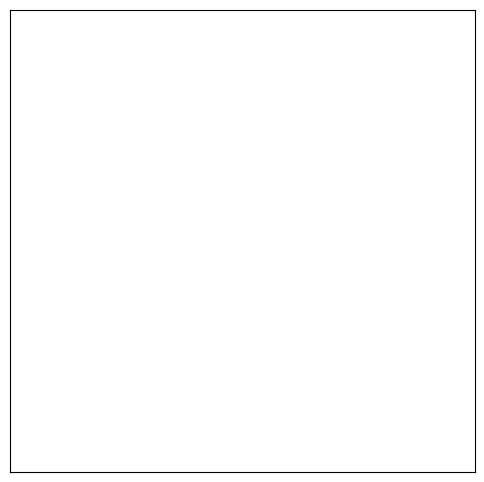

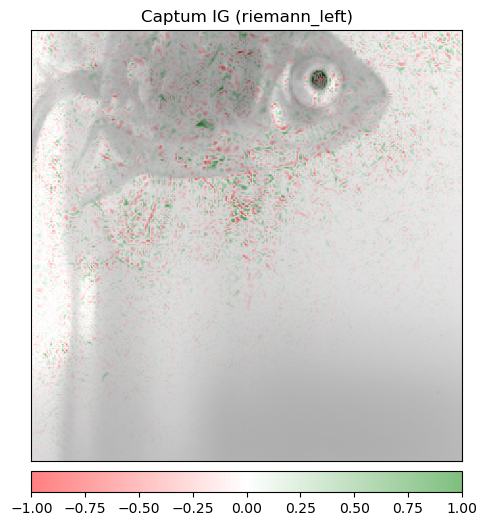

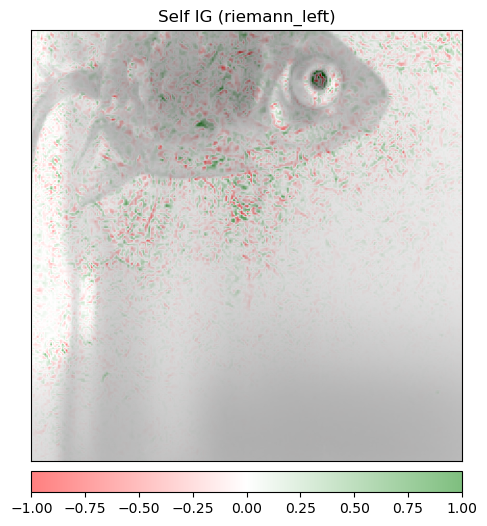

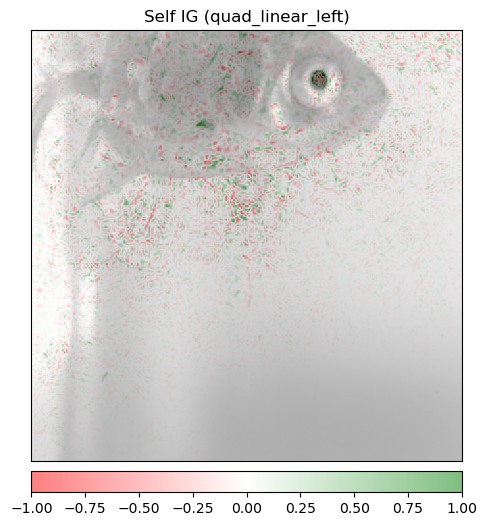

In [43]:
### YOUR CODE HERE:
idx = 0
x = images_[idx:idx+1]

n_steps = 100
captum_method = 'riemann_left'
self_method_name = 'riemann'
self_method_side = 'left'
quad_method_name = 'quad_linear'

baseline = torch.zeros_like(x)
with torch.no_grad():
    logits = net(x)
    prob = torch.softmax(logits, dim=1)
    pred_class_id = int(logits.argmax(1).item())
    pred_class_name = classes[pred_class_id]
    pred_prob = float(prob[0, pred_class_id].item())


attr_cap, delta_cap = captum_ig(net, x, baseline, pred_class_id, captum_method, n_steps)
attr_self_r, delta_self_r = self_ig(net, x, baseline, pred_class_id, self_method_name, self_method_side, n_steps)
attr_self_q, delta_self_q = self_ig(net, x, baseline, pred_class_id, quad_method_name, self_method_side, n_steps)

print(f"Deltas: captum={abs(delta_cap).item()}, self_riemann={abs(delta_self_r)}, self_quad={abs(delta_self_q)}")

attr_cap_np = attr_cap.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
attr_self_r_np = attr_self_r.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
attr_self_q_np = attr_self_q.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

visualize_attributions(
    predicted_class=pred_class_name,
    predicted_probability=pred_prob,
    image=x.squeeze(0),
    attrs=[attr_cap_np, attr_self_r_np, attr_self_q_np],
    methods=['blended_heat_map', 'blended_heat_map', 'blended_heat_map'],
    titles=['Captum IG (riemann_left)', 'Self IG (riemann_left)', 'Self IG (quad_linear_left)']
)

# Computing Characterization Score

Using the Integrated Gradients (IG) algorithm you implemented earlier, compute the **fidelity metrics** and summarize them with the **characterization score** for a trained image classifier.  
Refer to the slides for all formal definitions of these metrics (Lecture 6, slides 7 to 11).
You have been given some helper functions to help implement the compute_fid_plus and compute_fid_minus functions.

---

## Additional Information
- **Pixel selection:** Select the **top 50%** of pixels (ties broken arbitrarily) based on your IG attribution scores.  
- **Removal method:** To remove pixels, simply **zero them out**.  
- **Keep-only method:** Keep the selected pixels and set all others to zero.

---

## Experiment Values
- **Dataset:** Use the 4-image dataset provided.  
- **IG settings:**  
  - Method: **Riemann**  
  - Side: **Left**  
  - Steps: **50**

---

## What to Compute
For the dataset, compute and report:
1. $\mathrm{fid}_+$   
2. $\mathrm{fid}_-$   
3. **Characterization score**   

---


In [40]:
from typing import Dict
import torch
import numpy as np


@torch.no_grad()
def predict_top1(model: torch.nn.Module, x: torch.Tensor) -> int:
    """
    Return argmax class index for a single-batch input tensor x of shape (1, C, H, W).
    Assumes model(x) -> (1, num_classes) logits.
    """
    model.eval()
    logits = model(x)
    return int(logits.argmax(1).item())


def make_top_percent_mask(attributions: np.ndarray, top_percent: float) -> torch.BoolTensor:
    """
    Build a boolean HxW mask selecting the top `top_percent` pixels by saliency.

    Args:
        attributions: numpy array of shape (H, W, C) with IG attributions per channel.
        top_percent:  float in (0, 100], e.g., 10.0 means top 10% pixels are selected.

    Returns:
        torch.BoolTensor of shape (H, W): True for selected (top) pixels, False otherwise.
    """
    # Collapse channels by L1 (sum of absolute attributions), shape -> (H, W)
    saliency = torch.from_numpy(attributions).permute(2, 0, 1).abs().sum(0)

    H, W = saliency.shape
    k = max(1, int((top_percent / 100.0) * (H * W)))  # number of pixels to select

    flat = saliency.view(-1)
    topk = torch.topk(flat, k=k, largest=True).indices

    mask = torch.zeros_like(flat, dtype=torch.bool)
    mask[topk] = True
    return mask.view(H, W)


def remove_selected_pixels(image: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
    """
    Zero out the SELECTED pixels (mask==True) and keep everything else.
    image: (1, C, H, W)
    mask:  (H, W)
    """
    keep = (~mask).to(image.dtype)[None, None, :, :]  # (1,1,H,W) broadcast
    return image * keep


def keep_only_selected_pixels(image: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
    """
    Keep ONLY the SELECTED pixels (mask==True), zero out the rest.
    image: (1, C, H, W)
    mask:  (H, W)
    """
    keep = mask.to(image.dtype)[None, None, :, :]  # (1,1,H,W) broadcast
    return image * keep


def _characterization(fid_plus: float, fid_minus: float) -> float:
    """
    Computes the characterization score
    """
    a = float(fid_plus)
    b = float(1.0 - fid_minus)
    s = a + b
    return 0.0 if s <= 0.0 else (2.0 * a * b) / s


def compute_fid_plus(
    model: torch.nn.Module,
    images: torch.Tensor,           # (N, C, H, W)
    top_percent: float,
    *,
    self_ig,                        
    ig_method: str = "riemann",
    ig_side: str = "left",
    ig_steps: int = 50,
) -> float:
    """
    TASK: Implement fid_+

    Inputs:
      - model:      torch.nn.Module on CPU or GPU (we will eval() it here).
      - images:     (N, C, H, W) float tensor in [0,1] or similar.
      - top_percent: e.g., 10.0 for top 10%.
      - self_ig:    a provided function that returns (attrs_hwc, extra), where
                     attrs_hwc is (H, W, C) numpy array of attributions for x.
      - ig_method/ig_side/ig_steps: parameters forwarded to self_ig.

    Output:
      - float fid_plus in [0,1]
    """
    model = model.to("cpu").eval()
    images = images.to("cpu")
    matches = 0

    for i in range(images.shape[0]):
        x = images[i:i+1]                  # (1, C, H, W)
        baseline = torch.zeros_like(x)
        #Code Here:
        predicted_class = predict_top1(model, x)


        attributions, _ = self_ig(model, x, baseline, predicted_class, ig_method, ig_side, n_steps= ig_steps)
        attr_reshaped = attributions.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        mask = make_top_percent_mask(attr_reshaped, top_percent)
        image = remove_selected_pixels(x, mask)
        updated = predict_top1(model, image)
        matches += int(updated == predicted_class)

    fid_plus = 1 - matches / images.shape[0]

    return float(fid_plus)


def compute_fid_minus(
    model: torch.nn.Module,
    images: torch.Tensor,           
    top_percent: float,
    *,
    self_ig,                        
    ig_method: str = "riemann",
    ig_side: str = "left",
    ig_steps: int = 50,
) -> float:
    """
    TASK: Implement fid_-

    Inputs/Output: same conventions as compute_fid_plus.
    """
    model = model.to("cpu").eval()
    images = images.to("cpu")
    matches = 0

    for i in range(images.shape[0]):
        x = images[i:i+1]                  # (1, C, H, W)
        baseline = torch.zeros_like(x)
        #Code Here:
        predicted_class = predict_top1(model, x)


        attributions, _ = self_ig(model, x, baseline, predicted_class, ig_method, ig_side, n_steps= ig_steps)
        attr_reshaped = attributions.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        mask = make_top_percent_mask(attr_reshaped, top_percent)
        image = keep_only_selected_pixels(x, mask)
        updated = predict_top1(model, image)
        matches += int(updated == predicted_class)

    fid_minus = 1 - matches / images.shape[0]

    return float(fid_minus)


def evaluate_batch_characterization(
    model: torch.nn.Module,
    images: torch.Tensor,           # (N, C, H, W)
    top_percent: float = 10.0,
    *,
    self_ig,                        # pass-through to the metric functions
    ig_method: str = "riemann",
    ig_side: str = "left",
    ig_steps: int = 50,
) -> Dict[str, float]:
    """
    Compute fid_+, fid_- on a batch, then combine via _characterization.

    """
    fid_plus = compute_fid_plus(
        model, images, top_percent,
        self_ig=self_ig, ig_method=ig_method, ig_side=ig_side, ig_steps=ig_steps,
    )
    fid_minus = compute_fid_minus(
        model, images, top_percent,
        self_ig=self_ig, ig_method=ig_method, ig_side=ig_side, ig_steps=ig_steps,
    )
    char = _characterization(fid_plus, fid_minus)
    return {"fid_plus": fid_plus, "fid_minus": fid_minus, "characterization": char, "n": int(images.shape[0])}


def evaluate_loader_characterization(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    top_percent: float = 10.0,
    *,
    self_ig,                        # pass-through to the metric functions
    ig_method: str = "riemann",
    ig_side: str = "left",
    ig_steps: int = 50,
) -> Dict[str, float]:
    """
    Dataset-level evaluation: average the batch metrics over the entire dataloader.
    """
    total = 0
    sum_fp = 0.0
    sum_fm = 0.0

    for imgs, _ in dataloader:  # we don't need labels for these metrics
        out = evaluate_batch_characterization(
            model=model,
            images=imgs,
            top_percent=top_percent,
            self_ig=self_ig,
            ig_method=ig_method,
            ig_side=ig_side,
            ig_steps=ig_steps,
        )
        n = out["n"]
        total += n
        sum_fp += out["fid_plus"] * n
        sum_fm += out["fid_minus"] * n

    fid_plus = sum_fp / max(total, 1)
    fid_minus = sum_fm / max(total, 1)
    char = _characterization(fid_plus, fid_minus)
    return {"fid_plus": fid_plus, "fid_minus": fid_minus, "characterization": char}


In [41]:
evaluate_loader_characterization(
    model = net,
    dataloader = dataloader,
    top_percent = 50.0,
    self_ig = self_ig,                        # pass-through to the metric functions
    ig_method = "riemann",
    ig_side =  "left",
    ig_steps = 50)

{'fid_plus': 1.0, 'fid_minus': 0.5, 'characterization': 0.6666666666666666}